# Analytics - Product Quality

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: YYYY/0X
##### Professor: Hilmer Neri

##### Members:

- Member x
- Member y

### LIBRARIES

In [767]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os
import re

# Deal with visualization
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [768]:
fig = plt.figure(figsize=(20, 10))

<Figure size 1440x720 with 0 Axes>

### DATAFRAME SETTINGS

In [769]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [770]:
language = [['fga-eps-mds-2022-1-PUMA-Frontend', 'js'],
            ['fga-eps-mds-2022-1-PUMA-AlocateService', 'js'],
            ['fga-eps-mds-2022-1-PUMA-ApiGateway', 'js'],
            ['fga-eps-mds-2022-1-PUMA-NotifyService', 'js'],
            ['fga-eps-mds-2022-1-PUMA-ProjectService', 'js'],
            ['fga-eps-mds-2022-1-PUMA-UserService', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

### SonarCloud

##### Path to the folder with all your jsons

In [771]:
jsons = glob('analytics-raw-data/*.json')

In [772]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:
        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2022.1-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [773]:
base_component_df = create_base_component_df(jsons)

<ipython-input-772-8cf5b077493c>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
<ipython-input-772-8cf5b077493c>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
<ipython-input-772-8cf5b077493c>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
<ipython-input-772-8cf5b077493c>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
<ipython-input-772-8cf5b077493c>:21: FutureWarning: The frame.append method is deprecated and will b

In [774]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
47,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
48,functions,5,NaN,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
49,security_rating,1.0,True,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
50,files,5,NaN,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
51,complexity,12,NaN,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
52,ncloc,287,NaN,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
53,comment_lines_density,0.0,False,fga-eps-mds-2022-1-PUMA-AlocateService-08-01-2...,AlocateService,3.1.1
84,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-PUMA-AlocateService-09-07-2...,AlocateService,3.1.1
85,functions,5,NaN,fga-eps-mds-2022-1-PUMA-AlocateService-09-07-2...,AlocateService,3.1.1
86,security_rating,1.0,True,fga-eps-mds-2022-1-PUMA-AlocateService-09-07-2...,AlocateService,3.1.1


#### Create dataframe per file

In [775]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [776]:
def get_files_df(df):
    
    files = df[df['qualifier'] == 'FIL']
    
    files = files.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])
    
    return files

In [777]:
from cmath import nan


def get_dir_df(df):
    dirs = df[df["qualifier"] == "DIR"]     

    newdf = pd.to_numeric(dirs["tests"])
    
    max_value_index = newdf.idxmax()      
    
    return dirs.loc[max_value_index]

In [778]:
def get_uts_df(df):
    dirs = df[df['qualifier'] == 'UTS']     

    dirs = dirs.dropna(subset=['test_execution_time'])          
    
    return dirs

In [779]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        
        ncloc_value = 0;
        
        for valores in component['measures']:

            if valores['metric'] == 'ncloc':
                ncloc_value = float(valores['value'])
                break
    
        if (component['qualifier'] == 'FIL') & (ncloc_value > 0) or (component['qualifier'] == 'DIR') or (component['qualifier'] == 'UTS'):                       
            file_json.append(component)

    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    df2 = pd.DataFrame(columns = df_columns)
    df3 = pd.DataFrame(columns = df_columns)
    
    
    for file in json:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        df.at[file['path'], measure['metric']] = measure['value']

                    df['qualifier'] = file['qualifier'] 

                elif file['qualifier'] == 'UTS':  
                    for measure in file['measures']:
                        df3.at[file['path'], measure['metric']] = measure['value']

                    df3['qualifier'] = file['qualifier'] 
                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        df2.at[file['path'], measure['metric']] = measure['value']
                    df2['qualifier'] = file['qualifier'] 
        except:
            pass

    df.reset_index(inplace = True)
    df2.reset_index(inplace = True)
    df3.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    df2 = df2.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    df3 = df3.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    dfFinal = pd.concat([df,df2,df3], axis=0)

    return dfFinal

def create_file_df(json_list):
    
    df = pd.DataFrame()
    dfDir = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)
                        
        file_name = os.path.basename(i)

        file_repository = re.split(r'-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json', file_name)[0]

        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = file_language)
        
        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['version'])
    
    return df

In [780]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

<ipython-input-779-ce0dcd135ac6>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
<ipython-input-779-ce0dcd135ac6>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
<ipython-input-779-ce0dcd135ac6>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
<ipython-input-779-ce0dcd135ac6>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
<ipython-input-779-ce0dcd135ac6>:80: FutureWarning: The frame.append method is deprecated and will b

array(['fga-eps-mds-2022-1-PUMA-UserService',
       'fga-eps-mds-2022-1-PUMA-AlocateService',
       'fga-eps-mds-2022-1-PUMA-Frontend',
       'fga-eps-mds-2022-1-PUMA-ApiGateway',
       'fga-eps-mds-2022-1-PUMA-NotifyService',
       'fga-eps-mds-2022-1-PUMA-ProjectService'], dtype=object)

#### Removing NaN

In [781]:
file_component_df = file_component_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

        #### Create dataframe per repository

In [782]:
# Example. You must replace repo1, repo1,..., for your repository's names

repo1_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-PUMA-Frontend']
repo2_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-PUMA-AlocateService']
repo3_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-PUMA-ApiGateway']
repo4_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-PUMA-NotifyService']
repo5_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-PUMA-ProjectService']
repo6_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-PUMA-UserService']

In [783]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [784]:
def m1(df):

    files_df = get_files_df(df)
    
    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)
    
    return density_non_complex_files

##### COMMENTS

In [785]:
def m2(df):

    files_df = get_files_df(df)
    
    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)
    
    return density_comment_files

##### DUPLICATIONS

In [786]:
def m3(df):

    files_df = get_files_df(df)
    
    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [787]:
def m4(df):

    dir_df = get_dir_df(df)
    print('1')

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
                   float(dir_df['tests'])
    print('2')
    print('passed_tests')

    return passed_tests

##### Fast test builds

In [788]:
def m5(df):

    dir_df = get_uts_df(df)
    
    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

##### Test coverage

In [789]:
def m6(df):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [790]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        print('m1_list', m1_list)
        m2_list.append(m2(version_df))
        print('m2_list', m2_list)
        m3_list.append(m3(version_df))
        m4_list.append(0)
        m5_list.append(0)
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [791]:
repo1 = create_metrics_df(repo1_df)
repo2 = create_metrics_df(repo2_df)
repo3 = create_metrics_df(repo3_df)
repo4 = create_metrics_df(repo4_df)
repo5 = create_metrics_df(repo5_df)
repo6 = create_metrics_df(repo6_df)

m1_list [0.8846153846153846]
m2_list [0.038461538461538464]
m1_list [0.8846153846153846, 0.8846153846153846]
m2_list [0.038461538461538464, 0.038461538461538464]
m1_list [0.8846153846153846, 0.8846153846153846, 0.9440559440559441]
m2_list [0.038461538461538464, 0.038461538461538464, 0.006993006993006993]
m1_list [0.8846153846153846, 0.8846153846153846, 0.9440559440559441, 0.9523809523809523]
m2_list [0.038461538461538464, 0.038461538461538464, 0.006993006993006993, 0.0]


### Data visualization

- You must do this for each of your repositories

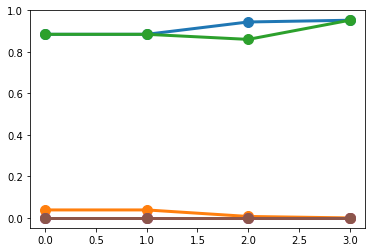

In [792]:
plt.plot(repo1['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m6'], linewidth=3, marker='o', markersize=10)

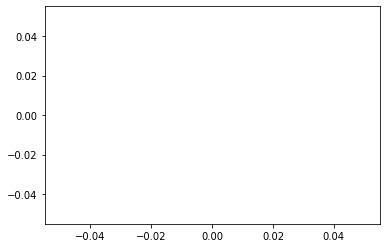

In [793]:

plt.plot(repo2['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m6'], linewidth=3, marker='o', markersize=10)

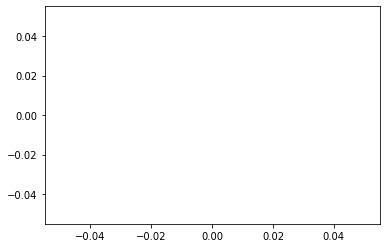

In [794]:
plt.plot(repo3['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m6'], linewidth=3, marker='o', markersize=10)

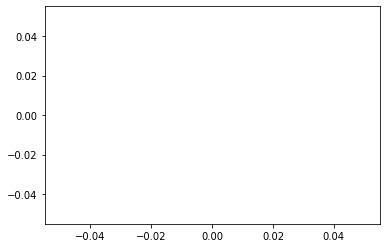

In [795]:
plt.plot(repo4['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo4['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo4['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo4['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo4['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo4['m6'], linewidth=3, marker='o', markersize=10)

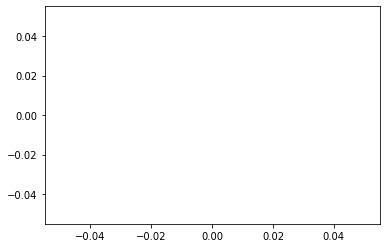

In [796]:
plt.plot(repo5['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo5['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo5['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo5['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo5['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo5['m6'], linewidth=3, marker='o', markersize=10)

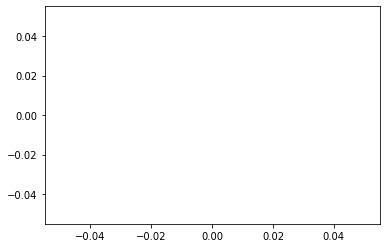

In [797]:
plt.plot(repo6['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo6['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo6['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo6['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo6['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo6['m6'], linewidth=3, marker='o', markersize=10)

### Quality factor and aspect aggregation

- You must do this for each of your repositories

In [817]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5

repo1['code_quality'] = ((repo1['m1']*pm1) + (repo1['m2']*pm2) + (repo1['m3']*pm3)) * psc1
repo2['code_quality'] = ((repo2['m1']*pm1) + (repo2['m2']*pm2) + (repo2['m3']*pm3)) * psc1
repo3['code_quality'] = ((repo3['m1']*pm1) + (repo3['m2']*pm2) + (repo3['m3']*pm3)) * psc1
repo4['code_quality'] = ((repo4['m1']*pm1) + (repo4['m2']*pm2) + (repo4['m3']*pm3)) * psc1
repo5['code_quality'] = ((repo5['m1']*pm1) + (repo5['m2']*pm2) + (repo5['m3']*pm3)) * psc1
repo6['code_quality'] = ((repo6['m1']*pm1) + (repo6['m2']*pm2) + (repo6['m3']*pm3)) * psc1

repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2
repo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2
repo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2
repo4['testing_status'] = ((repo4['m4']*pm4) + (repo4['m5']*pm5) + (repo4['m6']*pm6)) * psc2
repo5['testing_status'] = ((repo5['m4']*pm4) + (repo5['m5']*pm5) + (repo5['m6']*pm6)) * psc2
repo6['testing_status'] = ((repo6['m4']*pm4) + (repo6['m5']*pm5) + (repo6['m6']*pm6)) * psc2

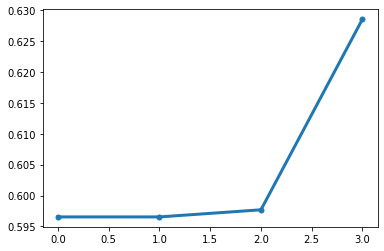

In [818]:
plt.plot(repo1['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo4['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo5['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo6['code_quality'], linewidth=3, marker='o', markersize=5)

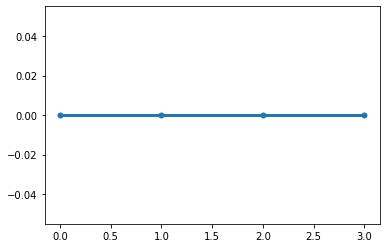

In [819]:

plt.plot(repo1['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo4['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo5['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo6['testing_status'], linewidth=3, marker='o', markersize=5)

In [821]:
repo1['Maintainability'] = repo1['code_quality'] * pc1
repo1['Reliability'] = repo1['testing_status'] * pc2
repo1['total'] = repo1['Maintainability'] + repo1['Reliability']

repo2['Maintainability'] = repo2['code_quality'] * pc1
repo2['Reliability'] = repo2['testing_status'] * pc2
repo2['total'] = repo2['Maintainability'] + repo2['Reliability']

repo3['Maintainability'] = repo3['code_quality'] * pc1
repo3['Reliability'] = repo3['testing_status'] * pc2
repo3['total'] = repo3['Maintainability'] + repo3['Reliability']

repo4['Maintainability'] = repo4['code_quality'] * pc1
repo4['Reliability'] = repo4['testing_status'] * pc2
repo4['total'] = repo4['Maintainability'] + repo4['Reliability']

repo5['Maintainability'] = repo5['code_quality'] * pc1
repo5['Reliability'] = repo5['testing_status'] * pc2
repo5['total'] = repo5['Maintainability'] + repo5['Reliability']

repo6['Maintainability'] = repo6['code_quality'] * pc1
repo6['Reliability'] = repo6['testing_status'] * pc2
repo6['total'] = repo6['Maintainability'] + repo6['Reliability']

In [822]:
repo1

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.884615,0.038462,0.884615,0,0,0.0,fga-eps-mds-2022-1-PUMA-Frontend,3.1.3,12078,0.596538,0.0,0.298269,0.0,0.298269
1,0.884615,0.038462,0.884615,0,0,0.0,fga-eps-mds-2022-1-PUMA-Frontend,3.1.4,48312,0.596538,0.0,0.298269,0.0,0.298269
2,0.944056,0.006993,0.860140,0,0,0.0,fga-eps-mds-2022-1-PUMA-Frontend,3.1.5,75758,0.597692,0.0,0.298846,0.0,0.298846
3,0.952381,0.000000,0.952381,0,0,0.0,fga-eps-mds-2022-1-PUMA-Frontend,3.1.6,107677,0.628571,0.0,0.314286,0.0,0.314286


(0.1, 1.1)

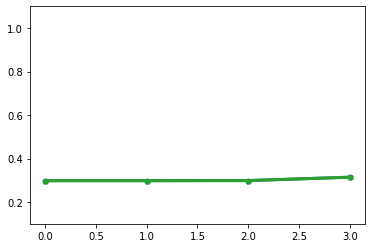

In [803]:
plt.plot(repo1['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo1['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo1['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

In [804]:
repo2

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total


Ellipsis

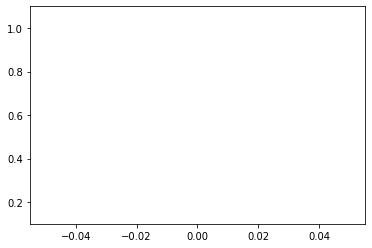

In [805]:
plt.plot(repo2['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo2['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

plt.plot(repo2['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo2['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

plt.plot(repo3['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo3['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

plt.plot(repo4['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo4['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo4['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

plt.plot(repo5['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo5['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo5['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

plt.plot(repo6['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(repo6['Reliability'], linewidth=3, marker='*', markersize=5)
plt.plot(repo6['total'], linewidth=3, marker='X', markersize=5)

plt.ylim(0.1,1.1)

### You must do the total plot and the statics analysis for the repository with more versions.

In [806]:
# Building descriptive statistics dataframe. You must replace YourRepoName for your repository name with more product versions.

metrics_df = pd.concat([repo1, repo2, repo3, repo4, repo5, repo6], ignore_index=True)

more_versions_repo = metrics_df[metrics_df['repository'] == 'YourRepoName']

def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

maintainability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [807]:
print(maintainability_stats)

Empty DataFrame
Columns: [mean, mode, median, std, var, min, max]
Index: []


In [808]:
print(reliability_stats)

Empty DataFrame
Columns: [mean, mode, median, std, var, min, max]
Index: []


### Plotting the aggregated quality characteristic indicator

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae44d601c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae44d60760>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae44d51eb0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fae44d60d00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fae44d60fd0>,
 'means': []}

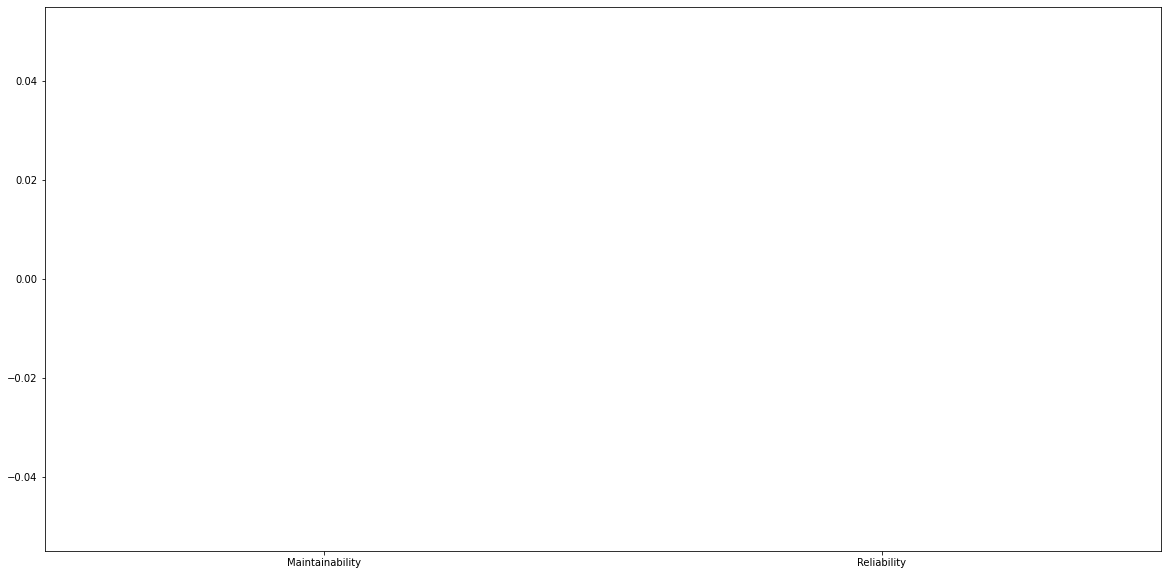

In [809]:
plt.figure(figsize=(20, 10))

# boxplot
plt.boxplot([more_versions_repo['Maintainability'], more_versions_repo['Reliability']],
labels=['Maintainability', 'Reliability'])

### Plotting the aggregated repository quality indicator

(0.1, 1.0)

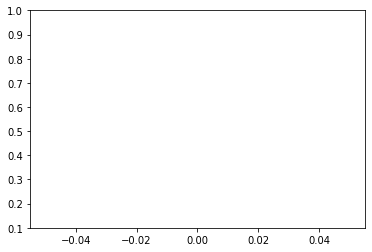

In [810]:
plt.plot(more_versions_repo['total'], linewidth=3, marker='o', markersize=5)

plt.ylim(.1,1)

In [812]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('fga-eps-mds-2022-1-PUMA-Doc-{}.xlsx'.format(currentDateTime), index = False)

metrics_df.to_csv('fga-eps-mds-2022-1-PUMA-Doc-{}.csv'.format(currentDateTime), index = False)